In [1]:
%cd ~/NetBeansProjects/ExpLosion/
from notebooks.common_imports import *

/Volumes/LocalDataHD/m/mm/mmb28/NetBeansProjects/ExpLosion


In [28]:
# reported accuracies: Add=50%, Mult=57%, SOTA=81.6 (Turney holistic model)
df = pd.read_csv('../thesisgenerator/intrinsic_turney_phraselevel.csv')

In [29]:
df.head()

,Unnamed: 0,unigrams,composer,coverage,kind,accuracy,folds
0,0,w2v-giga-100,Add,0.788991,strict,0,0
1,1,w2v-giga-100,Add,0.272018,relaxed,0,0
2,2,w2v-giga-100,Add,0.788991,strict,0,1
3,3,w2v-giga-100,Add,0.272018,relaxed,0,1
4,4,w2v-giga-100,Add,0.788991,strict,0,2


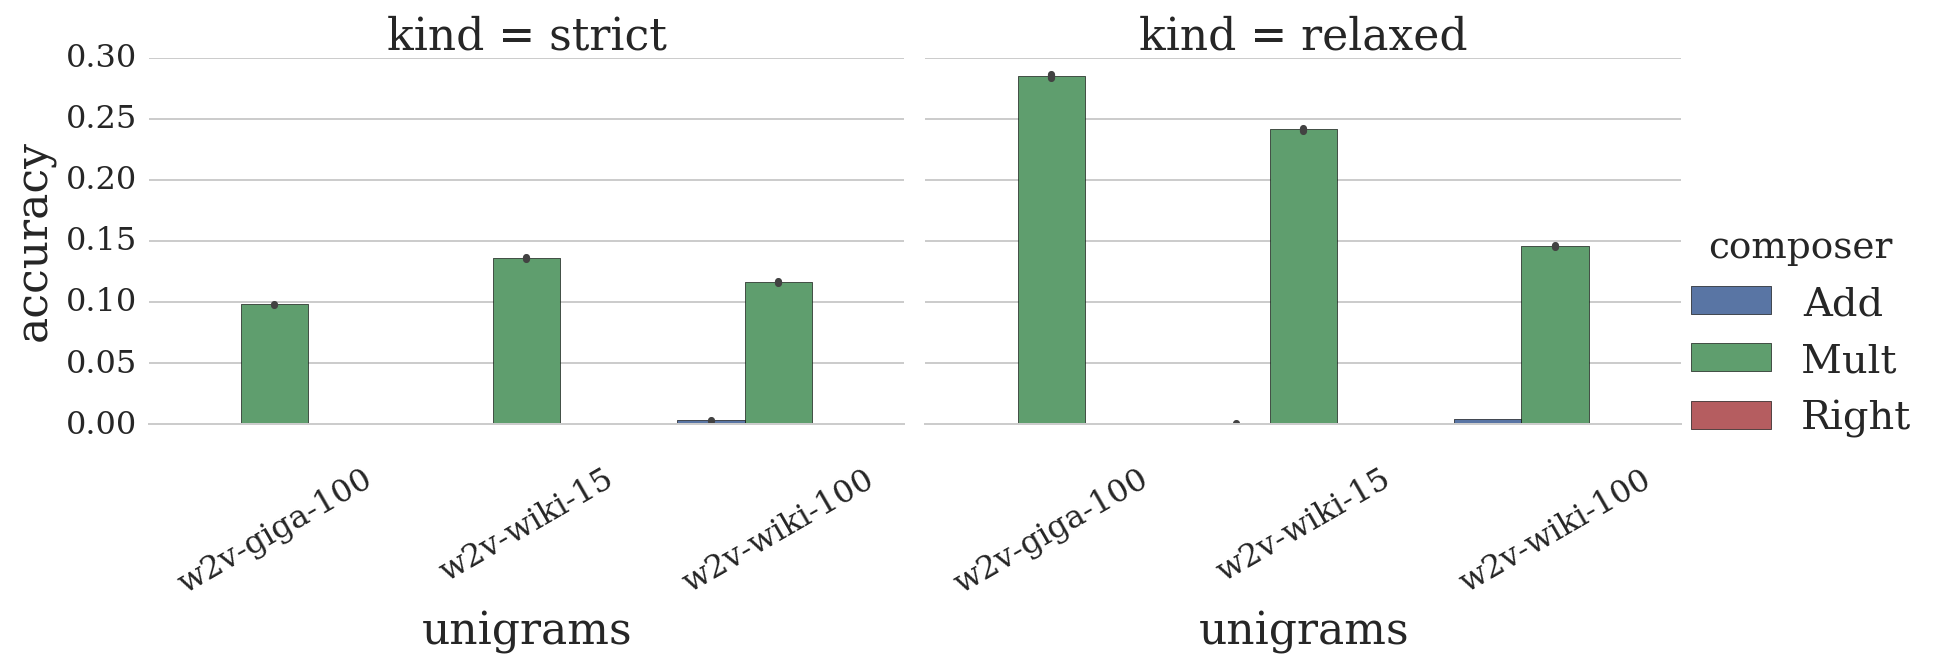

In [30]:
g = sns.factorplot(data=df, x='unigrams', hue='composer', col='kind',
                   y='accuracy', kind='bar', aspect=1.5)
g.set_xticklabels(rotation=30);
sns.despine(left=True)
plt.savefig('plot-intrinsic-turney.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)

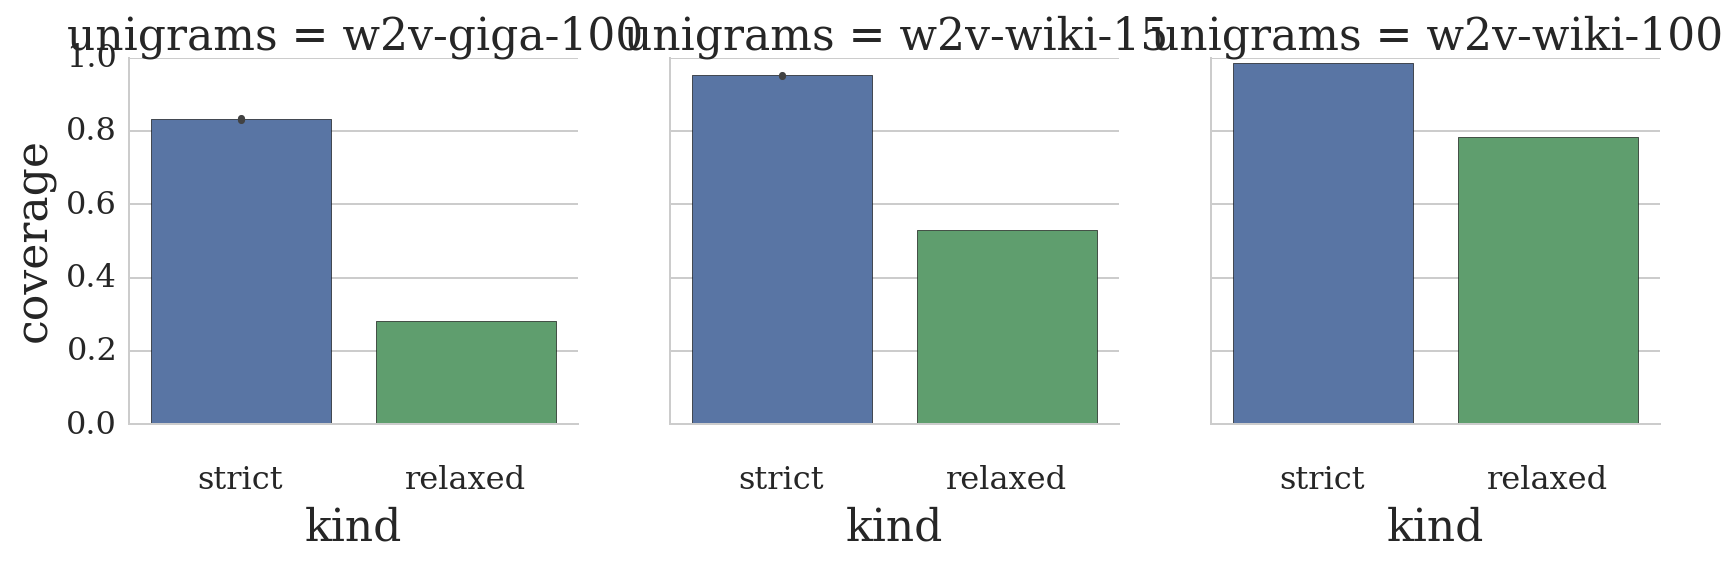

In [34]:
sns.factorplot(data=df, y='coverage', x='kind', col='unigrams', kind='bar')

In [31]:
df.groupby(['unigrams', 'composer', 'kind']).coverage.mean()

unigrams      composer  kind   
w2v-giga-100  Add       relaxed    0.272018
                        strict     0.788991
              Mult      relaxed    0.272018
                        strict     0.788991
              Right     relaxed    0.303211
                        strict     0.923853
w2v-wiki-100  Add       relaxed    0.781193
                        strict     0.982569
              Mult      relaxed    0.781193
                        strict     0.982569
              Right     relaxed    0.788532
                        strict     0.994954
w2v-wiki-15   Add       relaxed    0.524771
                        strict     0.937615
              Mult      relaxed    0.524771
                        strict     0.937615
              Right     relaxed    0.544037
                        strict     0.983486
Name: coverage, dtype: float64

# Observations
 - the task is messy- many questions cannot be answered by an average native speaker
 - need to count how many times we don't have a vector for the gold unigram- if we don't, we can't return it as a neighbour
  - without it, models attempt >95% of questions; with it only 30%-75%

Task is set up to test if models are skating by on lexical overlap. I am not disallowing it here as it would be slightly unfair, but then the results of this test will not be compatible with my DC results. Should do both versions.

See §4.2 in (Turney, 2012), esp. eq 30/31, table 15 for explanation of how he does the evaluation